# Interactias Geo Selected Network

One way of examining the impact of invasive species is to look at all their interactions and the interations those organisms have with each other. This full interaction network gives you an indication of whether a species might be a "keystone" species and therefore have a disproportionatly large impact.

In this step of the evolution of this script it will be adapted to quantify species by their occupancy.

I will harvest species interactions data from GloBI (https://www.globalbioticinteractions.org/) to discover the species that interact with an invasive species.
I will then harvest all the interactions for those species to create two tiers of interactions.
I will then count all the occurences of these in species in the Belgian datacube.
I will then visualize this.

This notebook takes considerable insperation and code from Yikang Li's project on GloBI (https://curiositydata.org/part1_globi_access/).


### For information: This is the list of invasive alien species of Union concern
|A|H|O|
|--|--|--|
|Acacia saligna|Heracleum sosnowskyi|Orconectes virilis|
|Acridotheres tristis|Herpestes javanicus|Oxyura jamaicensis|
|Ailanthus altissima|Humulus scandens|Pacifastacus leniusculus|
|Alopochen aegyptiaca|Hydrocotyle ranunculoides|Parthenium hysterophorus|
|Alternanthera philoxeroides|Impatiens glandulifera|Pennisetum setaceum|
|Andropogon virginicus|Lagarosiphon major|Perccottus glenii|
|Arthurdendyus triangulatus|Lepomis gibbosus|Persicaria perfoliata|
|Asclepias syriaca|Lespedeza cuneata|Plotosus lineatus|
|Baccharis halimifolia|Lithobates catesbeianus|Procambarus clarkii|
|Cabomba caroliniana|Ludwigia grandiflora|Procambarus fallax|
|Callosciurus erythraeus|Ludwigia peploides|Procyon lotor|
|Cardiospermum grandiflorum|Lygodium japonicum|Prosopis juliflora|
|Cortaderia jubata|Lysichiton americanus|Pseudorasbora parva|
|Corvus splendens|Microstegium vimineum|Pueraria montana|
|Ehrharta calycina|Muntiacus reevesi|Salvinia molesta|
|Eichhornia crassipes|Myocastor coypus|Sciurus carolinensis|
|Elodea nuttallii|Myriophyllum aquaticum|Sciurus niger|
|Eriocheir sinensis|Myriophyllum heterophyllum|Tamias sibiricus|
|Gunnera tinctoria|Nasua nasua|Threskiornis aethiopicus|
|Gymnocoronis spilanthoides|Nyctereutes procyonoides|Trachemys scripta|
|Heracleum mantegazzianum|Ondatra zibethicus|Triadica sebifera|
|Heracleum persicum|Orconectes limosus|Vespa velutina|

In [82]:
import sys
print(sys.version)

#Python 3.7.4 (default, Aug 9 2019, 18:34:13) [MSC v.1915 64 bit (AMD64)]
#pygbif 0.3.0

3.7.3 (default, Mar 27 2019, 17:13:21) [MSC v.1915 64 bit (AMD64)]


In [85]:
import pandas as pd
import re
import matplotlib.pyplot as plt
from pygbif import species
from pygbif import occurrences as occ
import sqlite3
from sqlite3 import Error
import pydot

### Setting up some parameters

In [86]:
# There is no point accepting all the species that have more than one record.
# There are too many casual records of plants and birds
thresholdForOccNum = 5
# If you want to exclude an interaction add it here
#interactionsToExclude = "visitsFlowersOf" #If you're not intersted in pollinators this will remove most of them
interactionsToExclude = "interactsWith"    #Many interactions in GloBI do not specify a specific interaction. You can get a cleaner netwot by excluding them
#interactionsToExclude = ""

In [115]:

## Define the country of interest
country  = 'BE'

## The occurrence cube has data for each year, but here we aggreagate years to get a more complete measure of occupancy.
## This parameter defines the year from where to consider records for the occupancy
year = 2000

## Define the place to find the data cube for occupancy data
## Currently the cube contains only Belgian data so that is all that can be used
database = r"..\..\data\cube.db" 

## Define the place to find the interaction data
globiDB = r"..\..\createGlobiDB\globi.db"

### Define the taxon for the notebook for which to find all interactions


In [95]:
taxon=input()

Ludwigia grandiflora


In [96]:
taxon = taxon.strip()

## Check to see if the taxon exits in GBIF

In [97]:
try:
    #NOTE: The function method name_suggest has a different behavior with regards to the gender of Latin names to name_backbone
    # If name_backbone is given a name in one gender it can still return the best match from the GBIF backbone if that
    # name is spelled as if it was another gender.
    #key = species.name_suggest(q=taxon, limit = 1)
    match = species.name_backbone(name=taxon, limit = 1)
    #print(key)
    
    # if there is no match this is returned form .name_backbone {'confidence': 100, 'matchType': 'NONE', 'synonym': False}
    if match['matchType'] == 'NONE':
        raise ValueError("TAXON NOT FOUND ON GBIF!")
    else:
        key = match['usageKey']
except ValueError as ve:
    print(ve)
    exit(1)




In [98]:

print('The taxon to be studied is ' + match['scientificName'])

The taxon to be studied is Ludwigia grandiflora (Michx.) Greuter & Burdet


### Just for information take a look at the interactions that the taxon has

In [10]:
# What are all the types of interactions involving taxon as source taxon?
#data[data['sourceTaxonName'] == taxon]['interactionTypeName'].unique()
try:
    connGlobi = sqlite3.connect(globiDB)
except Error as e:
    print(e)

In [11]:
curGlobi = connGlobi.cursor()
curGlobi.execute("SELECT interactionTypeName from globi  WHERE sourceTaxonSpeciesName = ? GROUP BY interactionTypeName;", (taxon,))
interactDataTaxon = curGlobi.fetchall()

In [12]:
interactDataTaxon

[('eats',), ('interactsWith',)]

In [13]:
curGlobi = connGlobi.cursor()
curGlobi.execute("SELECT interactionTypeName from globi  WHERE targetTaxonSpeciesName = ? GROUP BY interactionTypeName;", (taxon,))
interactDataTaxon = curGlobi.fetchall()
interactDataTaxon

[('ectoparasiteOf',), ('hasHost',), ('interactsWith',), ('parasiteOf',)]

## Get the primary interation data for the species in question

This is limited to the rank of species because otherwise the network can get very large with rather irrelivent higher taxa.
However, if no interactions are found at the species level it might be worth removing this restriction.

In [14]:
curGlobi = connGlobi.cursor()
#curGlobi.execute("SELECT * from globi  WHERE targetTaxonName = ? and interactionTypeName NOT IN (?);", \
if interactionsToExclude == "":
    curGlobi.execute("SELECT * from globi  WHERE targetTaxonSpeciesName = ?;", \
                 (taxon,))
else:
    curGlobi.execute("SELECT * from globi  WHERE targetTaxonSpeciesName = ? and interactionTypeName NOT IN (?);", \
                 (taxon,interactionsToExclude,))
interactDataTaxon = curGlobi.fetchall()

In [15]:
curGlobi = connGlobi.cursor()
#curGlobi.execute("SELECT * from globi  WHERE sourceTaxonName = ? and interactionTypeName NOT IN (?);", \
if interactionsToExclude == "":
    curGlobi.execute("SELECT * from globi  WHERE sourceTaxonSpeciesName = ?;", \
                 (taxon,))
else:
    curGlobi.execute("SELECT * from globi  WHERE sourceTaxonSpeciesName = ? and interactionTypeName NOT IN (?);", \
                 (taxon,interactionsToExclude,))
sources = curGlobi.fetchall()

In [16]:
interactDataTaxon.extend(sources)
len(interactDataTaxon)

81

In [17]:
# Convert to a Pandas dataframe
interactDataTaxon = pd.DataFrame(interactDataTaxon)

In [18]:
# Add column names
interactDataTaxon
interactDataTaxon.columns = ['sourceTaxonId', \
                                'sourceTaxonIds','sourceTaxonName','sourceTaxonRank','sourceTaxonPathNames', \
                                'sourceTaxonPathIds','sourceTaxonPathRankNames','sourceTaxonSpeciesName','sourceTaxonSpeciesId',\
                                'sourceTaxonGenusName','sourceTaxonGenusId','sourceTaxonFamilyName','sourceTaxonFamilyId',\
                                'sourceTaxonOrderName','sourceTaxonOrderId','sourceTaxonClassName','sourceTaxonClassId',\
                                'sourceTaxonPhylumName','sourceTaxonPhylumId','sourceTaxonKingdomName','sourceTaxonKingdomId',\
                                'sourceId','sourceOccurrenceId','sourceCatalogNumber','sourceBasisOfRecordId',\
                                'sourceBasisOfRecordName','sourceLifeStageId','sourceLifeStageName','sourceBodyPartId',\
                                'sourceBodyPartName','sourcePhysiologicalStateId','sourcePhysiologicalStateName', \
                                'sourceSexId', 'sourceSexName','interactionTypeName',\
                                'interactionTypeId','targetTaxonId','targetTaxonIds','targetTaxonName',\
                                'targetTaxonRank','targetTaxonPathNames','targetTaxonPathIds','targetTaxonPathRankNames',\
                                'targetTaxonSpeciesName','targetTaxonSpeciesId','targetTaxonGenusName','targetTaxonGenusId',\
                                'targetTaxonFamilyName','targetTaxonFamilyId','targetTaxonOrderName','targetTaxonOrderId',\
                                'targetTaxonClassName','targetTaxonClassId','targetTaxonPhylumName','targetTaxonPhylumId',\
                                'targetTaxonKingdomName','targetTaxonKingdomId','targetId','targetOccurrenceId',\
                                'targetCatalogNumber','targetBasisOfRecordId','targetBasisOfRecordName','targetLifeStageId',\
                                'targetLifeStageName','targetBodyPartId','targetBodyPartName','targetPhysiologicalStateId',\
                                'targetPhysiologicalStateName', 'targetSexId', 'targetSexName',\
                                'decimalLatitude','decimalLongitude','localityId',\
                                'localityName','eventDateUnixEpoch','argumentTypeId','referenceCitation',\
                                'referenceDoi','referenceUrl','sourceCitation','sourceNamespace',\
                                'sourceArchiveURI','sourceDOI','sourceLastSeenAtUnixEpoch']

## Get a list of all the primary interacting species

In [19]:
interactingTaxaData = interactDataTaxon.drop_duplicates()

In [20]:
primaryInteractingTaxa = interactingTaxaData['sourceTaxonName'].drop_duplicates()
len(primaryInteractingTaxa)

14

In [21]:
primaryInteractingTaxa = (primaryInteractingTaxa.append(interactingTaxaData['targetTaxonName']).drop_duplicates())
len(primaryInteractingTaxa)

62

In [22]:
primaryInteractingTaxa

0               Plegadiphilus threskiornis
1                    Colpocephalum tandani
3                       Ardeicola freemani
4                        Ibidoecus tandani
5                  Colpocephalum pygidiale
6                         Ardeicola clayae
7                   Ibidoecus threskiornis
10                    Ardeicola intermedia
11                     Ibidoecus insularis
12                                   Acari
21                                 Cestoda
22                               Patagifer
25                 Newcastle disease virus
28                Threskiornis aethiopicus
5     Threskiornis aethiopicus aethiopicus
28                                 Sorghum
29               Citrullus lanatus lanatus
30                            Cucumis melo
31                           Carica papaya
32                        Arachis hypogaea
33                                Zea mays
34                         Melia azedarach
35                              Ovis aries
37         

## A function to query the globi database

In [23]:
def secondaryDataInGlobi(conn, intaxon):
    cur = conn.cursor()
    if interactionsToExclude == "":
        cur.execute("SELECT * from globi  WHERE (targetTaxonSpeciesName = ? OR sourceTaxonSpeciesName = ?);", \
                 (intaxon,intaxon,))
    else:
        cur.execute("SELECT * from globi where (targetTaxonSpeciesName = ? OR sourceTaxonSpeciesName = ?) and interactionTypeName NOT IN (?);", \
                (intaxon,intaxon,interactionsToExclude,))
    return(cur.fetchall())

## Get all the secondary interactions

In [24]:
try:
    conn = sqlite3.connect(globiDB)
except Error as e:
    print(e)

In [25]:
secondarylist = []

for name in primaryInteractingTaxa:
    temp = secondaryDataInGlobi(conn, name)
    secondarylist.extend(temp)

In [26]:
# Convert to a Pandas dataframe
secondarylist = pd.DataFrame(secondarylist)

In [27]:
secondarylist.columns = ['sourceTaxonId', \
                                'sourceTaxonIds','sourceTaxonName','sourceTaxonRank','sourceTaxonPathNames', \
                                'sourceTaxonPathIds','sourceTaxonPathRankNames','sourceTaxonSpeciesName','sourceTaxonSpeciesId',\
                                'sourceTaxonGenusName','sourceTaxonGenusId','sourceTaxonFamilyName','sourceTaxonFamilyId',\
                                'sourceTaxonOrderName','sourceTaxonOrderId','sourceTaxonClassName','sourceTaxonClassId',\
                                'sourceTaxonPhylumName','sourceTaxonPhylumId','sourceTaxonKingdomName','sourceTaxonKingdomId',\
                                'sourceId','sourceOccurrenceId','sourceCatalogNumber','sourceBasisOfRecordId',\
                                'sourceBasisOfRecordName','sourceLifeStageId','sourceLifeStageName','sourceBodyPartId',\
                                'sourceBodyPartName','sourcePhysiologicalStateId','sourcePhysiologicalStateName',\
                                'sourceSexId', 'sourceSexName', 'interactionTypeName',\
                                'interactionTypeId','targetTaxonId','targetTaxonIds','targetTaxonName',\
                                'targetTaxonRank','targetTaxonPathNames','targetTaxonPathIds','targetTaxonPathRankNames',\
                                'targetTaxonSpeciesName','targetTaxonSpeciesId','targetTaxonGenusName','targetTaxonGenusId',\
                                'targetTaxonFamilyName','targetTaxonFamilyId','targetTaxonOrderName','targetTaxonOrderId',\
                                'targetTaxonClassName','targetTaxonClassId','targetTaxonPhylumName','targetTaxonPhylumId',\
                                'targetTaxonKingdomName','targetTaxonKingdomId','targetId','targetOccurrenceId',\
                                'targetCatalogNumber','targetBasisOfRecordId','targetBasisOfRecordName','targetLifeStageId',\
                                'targetLifeStageName','targetBodyPartId','targetBodyPartName','targetPhysiologicalStateId',\
                                'targetPhysiologicalStateName', 'targetSexId', 'targetSexName', \
                                'decimalLatitude','decimalLongitude','localityId',\
                                'localityName','eventDateUnixEpoch','argumentTypeId','referenceCitation',\
                                'referenceDoi','referenceUrl','sourceCitation','sourceNamespace',\
                                'sourceArchiveURI','sourceDOI','sourceLastSeenAtUnixEpoch']

In [28]:
allInteractionsData = interactingTaxaData.append(secondarylist)

In [29]:
allInteractionsData = allInteractionsData.drop_duplicates()


In [30]:
    cleanInteractDataTaxon = allInteractionsData[['sourceTaxonId', 'sourceTaxonName', 'sourceTaxonSpeciesName', 'sourceTaxonRank',
       'sourceTaxonFamilyName', 'interactionTypeName',
       'targetTaxonName','targetTaxonSpeciesName','targetTaxonRank', 'sourceCitation', 'sourceDOI'
        ]].dropna(subset=['targetTaxonSpeciesName','sourceTaxonSpeciesName'])

In [31]:
allSourceInteractingTaxa = cleanInteractDataTaxon['sourceTaxonSpeciesName'].drop_duplicates()
allTargetInteractingTaxa = cleanInteractDataTaxon['targetTaxonSpeciesName'].drop_duplicates()

In [32]:
allInteractingTaxa = allSourceInteractingTaxa.append(allTargetInteractingTaxa).drop_duplicates()
allInteractingTaxa.count()

3131

In [33]:
allInteractingTaxa.head()

0    Plegadiphilus threskiornis
1         Colpocephalum tandani
3            Ardeicola freemani
4             Ibidoecus tandani
5       Colpocephalum pygidiale
dtype: object

In [34]:
# How many different sort of interaction do I have left?
# Checking out all the interaction types
cleanInteractDataTaxon.groupby(cleanInteractDataTaxon['interactionTypeName']).size().sort_values(ascending = False)

interactionTypeName
hasHost                  22610
eats                      7228
parasiteOf                3917
pathogenOf                2770
preysOn                    448
endoparasiteOf             282
ectoparasiteOf             153
symbiontOf                 106
hasVector                   69
visitsFlowersOf             39
pollinates                  22
livesUnder                  14
adjacentTo                  11
coOccursWith                10
livesInsideOf                8
visits                       6
ecologicallyRelatedTo        5
kills                        2
hasDispersalVector           1
dtype: int64

### This function takes a name string and checks on GBIF to see if the name exists there.

In [35]:
def speciesExistsInGBIF(name, rank):
    try:
        match = species.name_backbone(name=name, rank=rank, limit = 1)

        # if there is no match this is returned from .name_backbone {'confidence': 100, 'matchType': 'NONE', 'synonym': False}
        if match['matchType'] == 'NONE':
            return False
        else:
            return match
    except ValueError as ve:
        print(ve)
        exit(1)

### Check that the species in question is actually found on GBIF

In [36]:
if(speciesExistsInGBIF(taxon, "species") == False):
    print("##### {0} has not been found on GBIF #####".format(taxon))

### Citation for the GBIF Backbone Taxonomy

In [114]:
from datetime import date
print("GBIF Secretariat (2019). GBIF Backbone Taxonomy. Checklist dataset https://doi.org/10.15468/39omei accessed via GBIF.org on ", date.today())

GBIF Secretariat (2019). GBIF Backbone Taxonomy. Checklist dataset https://doi.org/10.15468/39omei accessed via GBIF.org on  2020-06-20


### Check to see which taxa in the interaction network are found in GBIF and list those ones that are not

In [37]:
taxaFound = {}

print('Taxa from GLoBI, but not found in GBIF')
for name in allInteractingTaxa.items():
    GBIFName = speciesExistsInGBIF(name[1], "species")
    if GBIFName == False:
        taxaFound[name[1]] = False
        print(name[1])
    else:
        taxaFound[name[1]] = GBIFName['usageKey']
    

Taxa from GLoBI, but not found in GBIF

Newcastle disease virus
Watermelon silver mottle virus
Wild melon vein banding virus
Sudan watermelon mosaic virus
Melon partitivirus
Cucurbit chlorotic yellows virus
Nectria
Sphaerotheca
Papaya meleira virus
Papaya leaf curl Faisalabad virus
Papaya leaf curl alphasatellite
Spilarctia obliqua
Groundnut bud necrosis virus
Groundnut yellow spot virus
Groundnut ringspot virus
Maize stripe virus
Zea mays/Colletotrichum graminicola mixed EST library
Maize mosaic virus
Maize fine streak virus
Wheat mosaic virus
undetermined Cottoidei Lake Baikal
Mexican
Candidatus Phytoplasma solani
Maize bushy stunt phytoplasma
Zea mays chrysovirus 1
Maize-associated totivirus 3
Maize-associated totivirus 2
Maize-associated totivirus 1
Maize striate mosaic virus
Rotavirus
Entodinium sp.
Globodium sp.
Globodium gilruthi
Capillaria papillosus
Entodinium nanellum
Entodinium bursa
Entodinium dubardi
Entodinium furca
Entodinium caudatum
Eudiplodinium maggii
Enoploplastron 

In [38]:
# Convert to a Pandas dataframe
taxaFound = pd.DataFrame.from_dict(taxaFound, orient='index')

In [39]:
len(taxaFound)

3131

In [40]:
taxaFound

,0
Plegadiphilus threskiornis,1032805
Colpocephalum tandani,6936193
Ardeicola freemani,6939438
Ibidoecus tandani,6938495
Colpocephalum pygidiale,6936233
Ardeicola clayae,6939414
Ibidoecus threskiornis,6938483
Ardeicola intermedia,6939445
Ibidoecus insularis,6938503
,False


### This function takes a GBIF species key and counts how many occurences exist in the data cube

In [41]:
def speciesCountInCube(conn, key):
    cur = conn.cursor()
    cur.execute("SELECT COUNT(taxonKey) from (SELECT taxonKey FROM cube WHERE year > ? and taxonKey = ? GROUP BY eea_cell_code)", (year, key,))
    return(cur.fetchall())

### Loop over all the taxa that are in the interaction network and are in GBIF to find the ones that have been found in the country

In [42]:
taxaFoundInCountry = []

try:
    conn = sqlite3.connect(database)
except Error as e:
    print(e)

In [43]:
year

2000

In [44]:
for GBIFtaxon in taxaFound.iterrows():
    GBIFOccCount = speciesCountInCube(conn, GBIFtaxon[1][0])
    print(GBIFtaxon[0])
    if GBIFOccCount[0][0] > thresholdForOccNum and GBIFtaxon[0] != taxon: # The threshold for observations is not greater than one, due to all the casual records
        taxaFoundInCountry.append({'key': GBIFtaxon[1][0], 'species': GBIFtaxon[0], 'count': GBIFOccCount[0][0]})
        print('{0} with key {1} occurs in {2} km squares.'.format(GBIFtaxon[0],GBIFtaxon[1][0],GBIFOccCount[0][0]))
    elif GBIFtaxon[0] == taxon:
        taxaFoundInCountry.append({'key': GBIFtaxon[1][0], 'species': GBIFtaxon[0], 'count': GBIFOccCount[0][0]})
        print('{0} with key {1} occurs in {2} km squares.'.format(GBIFtaxon[0],GBIFtaxon[1][0],GBIFOccCount[0][0]))

Plegadiphilus threskiornis
Colpocephalum tandani
Ardeicola freemani
Ibidoecus tandani
Colpocephalum pygidiale
Ardeicola clayae
Ibidoecus threskiornis
Ardeicola intermedia
Ibidoecus insularis

Newcastle disease virus
Threskiornis aethiopicus
Threskiornis aethiopicus with key 2480764 occurs in 272 km squares.
Zenaida asiatica
Diaphania indica
Aphis (Aphis) gossypii
Aphis (Aphis) gossypii with key 9083295 occurs in 63 km squares.
Colias eurytheme
Vanessa cardui
Vanessa cardui with key 4299368 occurs in 12828 km squares.
Pyrrharctia isabella
Spodoptera exigua
Autographa californica
Diaphania nitidalis
Anisota stigma
Melittia riograndensis
Leptoglossus gonagra
Diabrotica virgifera
Acalymma vittatum
Acalymma vittatum with key 1047583 occurs in 7 km squares.
Anasa tristis
Fusarium oxysporum
Melon yellowing-associated virus
Erwinia tracheiphila
Acidovorax avenae
Cucurbit yellow stunting disorder virus
Melon necrotic spot virus
Watermelon mosaic virus
Zucchini yellow mosaic virus
Cucurbit aphid

Groundnut yellow spot virus
Psychrobacter alimentarius
Pseudomonas fluorescens
Enterobacter ludwigii
Sinorhizobium americanum
Mesorhizobium opportunistum
Cowpea aphid-borne mosaic virus
Exophiala pisciphila
Microdochium
Bacillus sphaericus
Ochrobactrum haematophilum
Scirtothrips dorsalis
Rhizobium leguminosarum
Groundnut ringspot virus
Trichogramma chilonis
Stenomesius japonicus
Brachymeria marmonti
Brachymeria minuta
Brachymeria phya
Brachymeria lasus
Elasmus brevicornis
Elasmus anticles
Plutarchia giraulti
Sympiesis dolichogaster
Stenomesius modicellus
Encarsia nigricephala
Encarsia citrella
Antrocephalus mitys
Euplectrus platyhypenae
Psilochalcis deceptor
Psilochalcis threa
Psilochalcis usta
Perilampus granulosus
Perilampus fulvicornis
Conura sanguiniventris
Conura side
Copidosoma truncatellum
Psilochalcis mirabilis
Goetheana shakespearei
Eurytoma tolidepepra
Homalotylus flaminius
Anagyrus mirzai
Aspergillus flavus
Botrytis cinerea
Tomato spotted wilt orthotospovirus
Bean common mos

Paracentrobia acuminata
Thinodytes clypeatus
Helicotylenchus multicinctus
Filenchus filiformis
Striga hermonthica
Gibberella fujikuroi
Gibberella zeae
Bipolaris maydis
Colletotrichum graminicola
Trichoderma virens
Curvularia lunata
Bipolaris zeicola
Exserohilum turcicum
Fusarium fujikuroi
Wheat streak mosaic virus
Rice stripe tenuivirus
Maize stripe tenuivirus
Zea mays/Colletotrichum graminicola mixed EST library
Maize mosaic virus
Maize fine streak virus
Wheat mosaic virus
Brome mosaic virus
Striga asiatica
Aceria tulipae
undetermined Cottoidei Lake Baikal
Rhynchobatus djiddensis
Tylenchorhynchus maximus
Tylenchorhynchus claytoni
Paratrichodorus porosus
Scutellonema brachyurum
Helicotylenchus digonicus
Pratylenchus vulnus
Pratylenchus neglectus
Meloidogyne chitwoodi
Longidorus breviannulatus
Hoplolaimus galeatus
Hoplolaimus columbus
Xiphinema rivesi
Xiphinema chambersi
Vittatidera zeaphila
Punctodera chalcoensis
Mexican
Dolichodorus heterocephalus
Candidatus Phytoplasma solani
Maize b

Proteus mirabilis
Theileria lestoquardi
Burkholderia pseudomallei
Mycoplasma arginini
Cryptosporidium bovis
Dermatophilus congolensis
Histoplasma capsulatum
Bovine herpesvirus 4
Streptococcus dysgalactiae
Clostridium sordellii
Trichophyton
Bartonella henselae
Clostridium septicum
Sarcocystis arieticanis
Rhipicephalus sanguineus
Linguatula serrata
Selenomonas ruminantium
Bovine viral diarrhea virus 2
Streptococcus suis
Actinobacillus lignieresii
Bacteroides fragilis
Bordetella bronchiseptica
Enterococcus faecium
Yersinia pseudotuberculosis
Proteus vulgaris
Rotavirus B
Bordetella parapertussis
Dugbe virus
Crimean-Congo hemorrhagic fever virus
Erysipelothrix rhusiopathiae
Bhanja virus
Corynebacterium renale
Leptospira borgpetersenii
Microsporum gypseum
Pasteurella trehalosi
Hepatitis E virus
Cryptosporidium andersoni
Wohlfahrtia magnifica
Setaria digitata
Rickettsia rickettsii
Chlamydophila pecorum
Mycoplasma bovigenitalium
Sarcoptes scabiei
Babesia ovis
Toxocara vitulorum
Aeromonas sobri

Tanaisia fedtschenkoi
Turkey astrovirus
Urogonimus macrostomus
Aeromonas veronii
Cellulosimicrobium funkei
Infectious bursal disease virus
Brachyspira innocens
Megamonas hypermegale
Veillonella parvula
Bacillus fordii
Gallibacterium salpingitidis
Enterococcus hirae
Curtuteria australis
Maritrema novaezealandense
Holomenopon leucoxanthum
Paramonostomum chabaudi
Notocotylus ephemera
Microphallus pygmaeus
Heterakis gallinae
RAILLIETINA (R.) PAUCITESTICULATA
APATEMON (A.) JAMESI
Sobolivicanthus gracilis
Polymorphus botulus
Ornithofilaria fallisensis
Echinostoma echinatum
Megrivirus A
Goose paramyxovirus SF02
Mallard associated gemycircularvirus 1
Mallard associated gemygorvirus 1
Duck megrivirus
Duck infectious anemia virus
Avihepatovirus A
Duck faeces associated circular DNA virus 3
Duck faeces associated circular DNA virus 2
Duck faeces associated circular DNA virus 1
Duck astrovirus GII.A
Duck astrovirus
Duck associated cyclovirus 1
Duck atadenovirus A
Aalivirus A
Avian sapelovirus
Avia

Ardea alba
Ardea alba with key 9752617 occurs in 11374 km squares.
Nyctanassa violacea
Lontra canadensis
Egretta thula
Tinca tinca
Tinca tinca with key 2362524 occurs in 747 km squares.
Lophodytes cucullatus
Lophodytes cucullatus with key 2498408 occurs in 85 km squares.
Southwellina dimorpha
Allocorrigia filiformis
Microphallus fonti
Arhythmorhynchus dimorpha
Aeromonas enteropelogenes
Psorospermium haeckeli
ARHYTHMORHYNCHUS (Southwillina) DIMORPHA
Nerodia cyclopion
Nerodia rhombifer
Procambarus clarkii
Procambarus clarkii with key 2227300 occurs in 114 km squares.
Ocypus olens
Ocypus olens with key 5746121 occurs in 24 km squares.
Natrix natrix
Lucilia ampullacea
Trichomonas batrachorum
Rhabdias bufonis
Opalina ranarum
Nyctotheroides cordiformis
Karotomorpha bufonis
Hexamita intestinalis
Entamoeba ranarum
Balantidium entozoon
Balantidium elongatum
Balantidium duodeni
Acanthocephalus ranae
Oswaldocruzia filiformis
Aplectana macintoshii
Lucilia bufonivora
Cosmocercoides pulchra
Oswaldoc

Acrida turrita
Chrysolina sanguinolenta
Chrysolina bankii
Scymnus schmidti
Scymnus schmidti with key 8583563 occurs in 11 km squares.
Hydrophilus piceus
Tropinota squalida
Oryctes nasicornis
Oryctes nasicornis with key 4995700 occurs in 27 km squares.
Ateuchetus semipunctatus
Dynastes tityus
Jekelius intermedius
Aclypea opaca
Silpha tristis
Dytiscus marginalis
Dytiscus marginalis with key 1038064 occurs in 11 km squares.
Licinus punctatulus
Acinopus picipes
Carabus morbillosus
Lophyra flexuosa
Helix aspersa
Crocidura russula
Crocidura russula with key 2435654 occurs in 10 km squares.
Dipodillus campestris
Apodemus sylvaticus
Apodemus sylvaticus with key 2437760 occurs in 13 km squares.
Mus spretus
Erithacus rubecula
Erithacus rubecula with key 2492462 occurs in 14444 km squares.
Gambusia affinis
Barbus barbus
Barbus barbus with key 5739539 occurs in 58 km squares.
Hemiaspis damelii
Anomalopus verreauxii
Morethia taeniopleura
Lygisaurus foliorum
Lampropholis guichenoti
Lampropholis deli

In [45]:
# Convert to a Pandas dataframe
taxaFoundInCountry = pd.DataFrame(taxaFoundInCountry)    

In [46]:
print("The number of species left in the network is {0}".format(len(taxaFoundInCountry)))

The number of species left in the network is 291


In [47]:
taxaFoundInCountry

,count,key,species
0,272,2480764,Threskiornis aethiopicus
1,63,9083295,Aphis (Aphis) gossypii
2,12828,4299368,Vanessa cardui
3,7,1047583,Acalymma vittatum
4,63,9083295,Aphis gossypii
5,23,2874570,Cucumis melo
6,785,2930137,Solanum lycopersicum
7,18,5219681,Sciurus carolinensis
8,7,1861644,Agrius convolvuli
9,133,1924713,Lampides boeticus


## Drawing a network of the interactions

Now that I have a list of all the species in the country I can use this as my nodes list for the network diagram.

In [48]:
#networkx seems to be a leading network tool in Python
import networkx as nx
import matplotlib.pyplot as plt

try:
    import pygraphviz
    from networkx.drawing.nx_agraph import write_dot
    print("using package pygraphviz")
except ImportError:
    try:
        import pydot
        from networkx.drawing.nx_pydot import write_dot
        print("using package pydot")
    except ImportError:
        print()
        print("Both pygraphviz and pydot were not found ")
        print("see  https://networkx.github.io/documentation/latest/reference/drawing.html")
        print()

using package pydot


In [49]:
# Create graphic object
G = nx.DiGraph()

In [50]:
# Match colours to interactions to distinguish them on the graph
colorInteractions = {'interaction':['pollinates', 'mutualistOf', 'eats', 'visitsFlowersOf', 'hasHost', 'parasiteOf', 'pathogenOf'],
        'colour':['r', 'g', 'b', 'y', 'm', 'w', 'c']}  

colorInteractionsDf = pd.DataFrame(colorInteractions)

#len(list(G.nodes))

## A quick look at the interaction data to see if it is what is expected

In [51]:
#cleanInteractDataTaxon.loc[(cleanInteractDataTaxon["sourceTaxonName"] == 'Apis mellifera') & (cleanInteractDataTaxon["targetTaxonName"] == 'Procyon lotor')]
cleanInteractDataTaxon.loc[(cleanInteractDataTaxon["sourceTaxonSpeciesName"] == 'Rousettus aegyptiacus')]

,sourceTaxonId,sourceTaxonName,sourceTaxonSpeciesName,sourceTaxonRank,sourceTaxonFamilyName,interactionTypeName,targetTaxonName,targetTaxonSpeciesName,targetTaxonRank,sourceCitation,sourceDOI
12855,GBIF:2432953,Rousettus aegyptiacus,Rousettus aegyptiacus,species,Pteropodidae,eats,Melia azedarach,Melia azedarach,species,"Geiselman, Cullen K. and Tuli I. Defex. 2015. ...",
12856,GBIF:2432953,Rousettus aegyptiacus,Rousettus aegyptiacus,species,Pteropodidae,eats,Melia azedarach,Melia azedarach,species,"Geiselman, Cullen K. and Tuli I. Defex. 2015. ...",
12857,GBIF:2432953,Rousettus aegyptiacus,Rousettus aegyptiacus,species,Pteropodidae,eats,Melia azedarach,Melia azedarach,species,"Geiselman, Cullen K. and Tuli I. Defex. 2015. ...",
12859,GBIF:2432953,Rousettus aegyptiacus,Rousettus aegyptiacus,species,Pteropodidae,eats,Melia azedarach,Melia azedarach,species,"Geiselman, Cullen K. and Tuli I. Defex. 2015. ...",
12860,GBIF:2432953,Rousettus aegyptiacus,Rousettus aegyptiacus,species,Pteropodidae,eats,Melia azedarach,Melia azedarach,species,"Geiselman, Cullen K. and Tuli I. Defex. 2015. ...",
12861,GBIF:2432953,Rousettus aegyptiacus,Rousettus aegyptiacus,species,Pteropodidae,eats,Melia azedarach,Melia azedarach,species,"Geiselman, Cullen K. and Tuli I. Defex. 2015. ...",
12865,GBIF:2432953,Rousettus aegyptiacus,Rousettus aegyptiacus,species,Pteropodidae,eats,Melia azedarach,Melia azedarach,species,"Geiselman, Cullen K. & Sarah Younger. 2020. Ba...",
12866,GBIF:2432953,Rousettus aegyptiacus,Rousettus aegyptiacus,species,Pteropodidae,eats,Melia azedarach,Melia azedarach,species,"Geiselman, Cullen K. & Sarah Younger. 2020. Ba...",
12867,GBIF:2432953,Rousettus aegyptiacus,Rousettus aegyptiacus,species,Pteropodidae,eats,Melia azedarach,Melia azedarach,species,"Geiselman, Cullen K. & Sarah Younger. 2020. Ba...",
12869,GBIF:2432953,Rousettus aegyptiacus,Rousettus aegyptiacus,species,Pteropodidae,eats,Melia azedarach,Melia azedarach,species,"Geiselman, Cullen K. & Sarah Younger. 2020. Ba...",


## Figure out which node has the most records. This is so that the graphic can be scaled.

In [52]:
if len(taxaFoundInCountry) > 0:
    maxRecords = taxaFoundInCountry.max()["count"]
    print(maxRecords)

15997


### Add the nodes to the graph

In [53]:
dictOfNodeSizes = {}

for index, row in taxaFoundInCountry.iterrows():
     # access data using column names
    #print('A: ', row['species'], row['count'], row['key'])
    G.add_node(row['species'], gbifkey=row['key'], occupancy = row['count'])
    #create a list of node sizes scaled for the network visulization
    dictOfNodeSizes[row['species']] = int(row['count']/maxRecords*100)

### Add edges to the graph

In [54]:
# iterate over the interacting species that are in GBIF and in the country with iterrows()
# Find the taxa found in the country that are in the source taxon name of the interation data,
# then add the edge if the target species is in the country too.

taxaFoundInCountry_copy = taxaFoundInCountry.copy()

for index, row in taxaFoundInCountry.iterrows():
    # loop over all the taxa finding if any of them are mentioned in the sourceTaxonName field
    for edge in cleanInteractDataTaxon.iterrows():
        if row['species'] == edge[1]['sourceTaxonSpeciesName']:
            #print('B: ', edge[1]['sourceTaxonName'], edge[1]['targetTaxonName'])
            # Some of the target species will not be in GBIF of in the country, so only add an edge where they are.
            for index2, row2 in taxaFoundInCountry_copy.iterrows():
                #print('E: ', row2['species'], edge[1]['targetTaxonName'])
                if row2['species'] == edge[1]['targetTaxonSpeciesName']: 
                    print('C: ', edge[1]['targetTaxonSpeciesName'], row['species'], edge[1]['interactionTypeName'])
                    G.add_edge(row['species'], edge[1]['targetTaxonSpeciesName'], label = edge[1]['interactionTypeName'])
                    
#len(list(G.nodes))


C:  Citrullus lanatus Threskiornis aethiopicus eats
C:  Cucumis melo Threskiornis aethiopicus eats
C:  Zea mays Threskiornis aethiopicus eats
C:  Bubulcus ibis Threskiornis aethiopicus eats
C:  Tringa totanus Threskiornis aethiopicus eats
C:  Anas querquedula Threskiornis aethiopicus eats
C:  Vanellus vanellus Threskiornis aethiopicus eats
C:  Fulica atra Threskiornis aethiopicus eats
C:  Phalacrocorax aristotelis Threskiornis aethiopicus eats
C:  Anas platyrhynchos Threskiornis aethiopicus eats
C:  Chroicocephalus ridibundus Threskiornis aethiopicus eats
C:  Larus argentatus Threskiornis aethiopicus eats
C:  Tringa totanus Threskiornis aethiopicus eats
C:  Vanellus vanellus Threskiornis aethiopicus eats
C:  Chlidonias niger Threskiornis aethiopicus eats
C:  Chroicocephalus ridibundus Threskiornis aethiopicus eats
C:  Himantopus himantopus Threskiornis aethiopicus eats
C:  Anguilla anguilla Threskiornis aethiopicus eats
C:  Rutilus rutilus Threskiornis aethiopicus eats
C:  Cyprinus car

C:  Zea mays Branta canadensis eats
C:  Zea mays Branta canadensis eats
C:  Zea mays Branta canadensis eats
C:  Zea mays Branta canadensis eats
C:  Zea mays Branta canadensis eats
C:  Zea mays Branta canadensis eats
C:  Zea mays Branta canadensis eats
C:  Zea mays Branta canadensis eats
C:  Zea mays Branta canadensis eats
C:  Zea mays Branta canadensis eats
C:  Zea mays Branta canadensis eats
C:  Zea mays Branta canadensis eats
C:  Zea mays Branta canadensis eats
C:  Zea mays Branta canadensis eats
C:  Zea mays Branta canadensis eats
C:  Zea mays Aythya collaris eats
C:  Zea mays Aythya collaris eats
C:  Zea mays Aythya collaris eats
C:  Zea mays Aythya collaris eats
C:  Zea mays Aythya collaris eats
C:  Zea mays Aythya collaris eats
C:  Zea mays Aythya collaris eats
C:  Zea mays Anser albifrons eats
C:  Zea mays Anser albifrons eats
C:  Zea mays Anser albifrons eats
C:  Zea mays Anser albifrons eats
C:  Zea mays Anser albifrons eats
C:  Zea mays Anser albifrons eats
C:  Zea mays Anser

C:  Anas platyrhynchos Haliaeetus leucocephalus eats
C:  Anas platyrhynchos Haliaeetus leucocephalus eats
C:  Anas platyrhynchos Haliaeetus leucocephalus eats
C:  Anas platyrhynchos Haliaeetus leucocephalus eats
C:  Anas platyrhynchos Haliaeetus leucocephalus eats
C:  Anas platyrhynchos Haliaeetus leucocephalus eats
C:  Anas platyrhynchos Haliaeetus leucocephalus eats
C:  Anas platyrhynchos Haliaeetus leucocephalus eats
C:  Anas platyrhynchos Haliaeetus leucocephalus eats
C:  Anas platyrhynchos Haliaeetus leucocephalus eats
C:  Anas platyrhynchos Haliaeetus leucocephalus eats
C:  Anas platyrhynchos Haliaeetus leucocephalus eats
C:  Anas platyrhynchos Haliaeetus leucocephalus eats
C:  Anas platyrhynchos Haliaeetus leucocephalus eats
C:  Anas platyrhynchos Haliaeetus leucocephalus eats
C:  Anas platyrhynchos Haliaeetus leucocephalus eats
C:  Anas platyrhynchos Haliaeetus leucocephalus eats
C:  Anas platyrhynchos Haliaeetus leucocephalus eats
C:  Anas platyrhynchos Haliaeetus leucocephalu

C:  Cyprinus carpio Haliaeetus leucocephalus eats
C:  Cyprinus carpio Haliaeetus leucocephalus eats
C:  Cyprinus carpio Haliaeetus leucocephalus eats
C:  Cyprinus carpio Haliaeetus leucocephalus eats
C:  Mytilus edulis Haliaeetus leucocephalus eats
C:  Mytilus edulis Haliaeetus leucocephalus eats
C:  Mytilus edulis Haliaeetus leucocephalus eats
C:  Mytilus edulis Haliaeetus leucocephalus eats
C:  Mytilus edulis Haliaeetus leucocephalus eats
C:  Mytilus edulis Haliaeetus leucocephalus eats
C:  Mytilus edulis Haliaeetus leucocephalus eats
C:  Fulica atra Buteo buteo eats
C:  Bufo bufo Buteo buteo preysOn
C:  Mytilus edulis Corvus corone eats
C:  Mytilus edulis Corvus corone eats
C:  Hirundo rustica Bubulcus ibis preysOn
C:  Hirundo rustica Bubulcus ibis eats
C:  Athalia lugens Bubulcus ibis eats
C:  Eristalis tenax Bubulcus ibis eats
C:  Mantis religiosa Bubulcus ibis eats
C:  Mantis religiosa Bubulcus ibis eats
C:  Mus musculus Bubulcus ibis eats
C:  Mus musculus Bubulcus ibis eats
C:  

C:  Anas platyrhynchos Buteo jamaicensis eats
C:  Anas platyrhynchos Buteo jamaicensis eats
C:  Anas platyrhynchos Buteo jamaicensis eats
C:  Anas platyrhynchos Buteo jamaicensis eats
C:  Anas platyrhynchos Buteo jamaicensis eats
C:  Anas platyrhynchos Buteo jamaicensis eats
C:  Anas platyrhynchos Buteo jamaicensis eats
C:  Anas platyrhynchos Bubo scandiacus eats
C:  Anas platyrhynchos Bubo scandiacus eats
C:  Anas platyrhynchos Bubo scandiacus eats
C:  Anas platyrhynchos Bubo scandiacus eats
C:  Anas platyrhynchos Bubo scandiacus eats
C:  Anas platyrhynchos Bubo scandiacus eats
C:  Anas platyrhynchos Falco rusticolus eats
C:  Anas platyrhynchos Anas platyrhynchos eats
C:  Ceratophyllum demersum Anas platyrhynchos eats
C:  Stuckenia pectinata Anas platyrhynchos eats
C:  Beckmannia syzigachne Anas platyrhynchos eats
C:  Scolochloa festucacea Anas platyrhynchos eats
C:  Lemna minor Anas platyrhynchos eats
C:  Triticum aestivum Anas platyrhynchos eats
C:  Echinochloa crus-galli Anas platy

C:  Pholis gunnellus Larus argentatus eats
C:  Sprattus sprattus Larus argentatus eats
C:  Clupea harengus Larus argentatus eats
C:  Somateria mollissima Larus argentatus eats
C:  Calidris alpina Larus argentatus preysOn
C:  Tringa erythropus Larus argentatus preysOn
C:  Recurvirostra avosetta Larus argentatus preysOn
C:  Pomatoschistus minutus Larus argentatus preysOn
C:  Pomatoschistus microps Larus argentatus preysOn
C:  Pleuronectes platessa Larus argentatus preysOn
C:  Platichthys flesus Larus argentatus preysOn
C:  Merlangius merlangus Larus argentatus preysOn
C:  Engraulis encrasicolus Larus argentatus preysOn
C:  Clupea harengus Larus argentatus preysOn
C:  Ammodytes tobianus Larus argentatus preysOn
C:  Asterias rubens Larus argentatus preysOn
C:  Crangon crangon Larus argentatus preysOn
C:  Carcinus maenas Larus argentatus preysOn
C:  Mytilus edulis Larus argentatus preysOn
C:  Mya arenaria Larus argentatus preysOn
C:  Ensis directus Larus argentatus preysOn
C:  Nephtys hombe

C:  Anguilla anguilla Perca fluviatilis eats
C:  Anguilla anguilla Perca fluviatilis preysOn
C:  Cyprinus carpio Perca fluviatilis preysOn
C:  Anguilla anguilla Squalius cephalus eats
C:  Rutilus rutilus Squalius cephalus eats
C:  Rutilus rutilus Squalius cephalus preysOn
C:  Anguilla anguilla Phalacrocorax carbo eats
C:  Anguilla anguilla Phalacrocorax carbo eats
C:  Anguilla anguilla Phalacrocorax carbo eats
C:  Anguilla anguilla Phalacrocorax carbo eats
C:  Anguilla anguilla Phalacrocorax carbo eats
C:  Anguilla anguilla Phalacrocorax carbo eats
C:  Anguilla anguilla Phalacrocorax carbo eats
C:  Anguilla anguilla Phalacrocorax carbo eats
C:  Anguilla anguilla Phalacrocorax carbo eats
C:  Anguilla anguilla Phalacrocorax carbo eats
C:  Anguilla anguilla Phalacrocorax carbo eats
C:  Anguilla anguilla Phalacrocorax carbo eats
C:  Anguilla anguilla Phalacrocorax carbo eats
C:  Anguilla anguilla Phalacrocorax carbo eats
C:  Anguilla anguilla Phalacrocorax carbo eats
C:  Anguilla anguilla 

C:  Alona affinis Cyprinus carpio eats
C:  Chaoborus flavicans Cyprinus carpio eats
C:  Physella acuta Cyprinus carpio eats
C:  Physella acuta Cyprinus carpio eats
C:  Leucaspius delineatus Cyprinus carpio preysOn
C:  Dreissena polymorpha Cyprinus carpio eats
C:  Dreissena polymorpha Cyprinus carpio eats
C:  Chelicorophium curvispinum Cyprinus carpio eats
C:  Alnus glutinosa Cyprinus carpio eats
C:  Physella acuta Cyprinus carpio preysOn
C:  Ctenopharyngodon idella Cyprinus carpio pathogenOf
C:  Procambarus clarkii Podiceps cristatus eats
C:  Procambarus clarkii Podilymbus podiceps eats
C:  Procambarus clarkii Podilymbus podiceps eats
C:  Procambarus clarkii Podilymbus podiceps eats
C:  Procambarus clarkii Podilymbus podiceps eats
C:  Procambarus clarkii Podilymbus podiceps eats
C:  Procambarus clarkii Podilymbus podiceps eats
C:  Procambarus clarkii Neovison vison eats
C:  Procambarus clarkii Ardea alba eats
C:  Procambarus clarkii Tinca tinca eats
C:  Procambarus clarkii Tinca tinca 

C:  Sterna hirundo Asio flammeus eats
C:  Sterna hirundo Asio flammeus eats
C:  Sterna hirundo Asio flammeus eats
C:  Sterna hirundo Asio flammeus eats
C:  Sterna hirundo Asio flammeus eats
C:  Sterna hirundo Asio flammeus eats
C:  Sterna hirundo Asio flammeus eats
C:  Sterna hirundo Asio flammeus eats
C:  Sterna hirundo Asio flammeus eats
C:  Sterna hirundo Asio flammeus eats
C:  Sterna hirundo Asio flammeus eats
C:  Sterna hirundo Asio flammeus eats
C:  Sterna hirundo Asio flammeus eats
C:  Sterna hirundo Asio flammeus eats
C:  Sterna hirundo Asio flammeus eats
C:  Sterna hirundo Asio flammeus eats
C:  Sterna hirundo Asio flammeus eats
C:  Sterna hirundo Asio flammeus eats
C:  Sterna hirundo Asio flammeus eats
C:  Sterna hirundo Asio flammeus eats
C:  Sterna hirundo Asio flammeus eats
C:  Sterna hirundo Asio flammeus eats
C:  Sterna hirundo Asio flammeus eats
C:  Sterna hirundo Asio flammeus eats
C:  Sterna hirundo Asio flammeus eats
C:  Osmerus eperlanus Sterna hirundo eats
C:  Gadu

In [55]:
# iterate over rows with iterrows()

# Find the taxa found in the country that are in the target taxon name of the interation data,
# then add the edge if the source species is in the country too.

for index, row in taxaFoundInCountry.iterrows():
    for edge in cleanInteractDataTaxon.iterrows():
        if row['species'] == edge[1]['targetTaxonName']:
            #print('D: ', edge[1]['sourceTaxonName'], edge[1]['targetTaxonName'])
            #G.add_node(edge[1]['sourceTaxonName'], gbifkey=row['key'])
            #dictOfNodeSizes[edge[1]['sourceTaxonName']] = int(row['count']/maxRecords*100)
            for index2, row2 in taxaFoundInCountry.iterrows():
                #print('E: ', row2['species'])
                if row2['species'] == edge[1]['sourceTaxonSpeciesName']: 
                    print('F: ', edge[1]['sourceTaxonSpeciesName'],edge[1]['targetTaxonSpeciesName'],edge[1]['interactionTypeName'])
                    G.add_edge(edge[1]['sourceTaxonSpeciesName'], row2['species'], label = edge[1]['interactionTypeName'])

F:  Threskiornis aethiopicus Cucumis melo eats
F:  Aphis (Aphis) gossypii Cucumis melo eats
F:  Aphis (Aphis) gossypii Cucumis melo eats
F:  Vanessa cardui Cucumis melo eats
F:  Vanessa cardui Cucumis melo eats
F:  Acalymma vittatum Cucumis melo hasHost
F:  Acalymma vittatum Cucumis melo hasHost
F:  Acalymma vittatum Cucumis melo hasHost
F:  Acalymma vittatum Cucumis melo hasHost
F:  Acalymma vittatum Cucumis melo hasHost
F:  Acalymma vittatum Cucumis melo hasHost
F:  Acalymma vittatum Cucumis melo hasHost
F:  Acalymma vittatum Cucumis melo hasHost
F:  Acalymma vittatum Cucumis melo hasHost
F:  Acalymma vittatum Cucumis melo hasHost
F:  Acalymma vittatum Cucumis melo hasHost
F:  Acalymma vittatum Cucumis melo hasHost
F:  Acalymma vittatum Cucumis melo hasHost
F:  Acalymma vittatum Cucumis melo hasHost
F:  Acalymma vittatum Cucumis melo hasHost
F:  Acalymma vittatum Cucumis melo hasHost
F:  Acalymma vittatum Cucumis melo hasHost
F:  Acalymma vittatum Cucumis melo hasHost
F:  Acalymma vi

F:  Aythya collaris Zea mays eats
F:  Anser albifrons Zea mays eats
F:  Anser albifrons Zea mays eats
F:  Anas discors Zea mays eats
F:  Anas americana Zea mays eats
F:  Anas americana Zea mays eats
F:  Alopochen aegyptiaca Zea mays eats
F:  Passer domesticus Zea mays eats
F:  Sturnus vulgaris Zea mays eats
F:  Sturnus vulgaris Zea mays eats
F:  Sturnus vulgaris Zea mays eats
F:  Sturnus vulgaris Zea mays eats
F:  Sturnus vulgaris Zea mays eats
F:  Columba livia Zea mays eats
F:  Plectrophenax nivalis Zea mays eats
F:  Calcarius lapponicus Zea mays eats
F:  Eremophila alpestris Zea mays eats
F:  Meleagris gallopavo Zea mays eats
F:  Meleagris gallopavo Zea mays eats
F:  Meleagris gallopavo Zea mays eats
F:  Phasianus colchicus Zea mays eats
F:  Meleagris gallopavo Zea mays eats
F:  Meleagris gallopavo Zea mays eats
F:  Meleagris gallopavo Zea mays eats
F:  Meleagris gallopavo Zea mays eats
F:  Phasianus colchicus Zea mays eats
F:  Meleagris gallopavo Zea mays eats
F:  Meleagris gallopa

F:  Buteo jamaicensis Anas platyrhynchos eats
F:  Buteo jamaicensis Anas platyrhynchos eats
F:  Accipiter gentilis Anas platyrhynchos eats
F:  Accipiter gentilis Anas platyrhynchos eats
F:  Buteo jamaicensis Anas platyrhynchos eats
F:  Accipiter gentilis Anas platyrhynchos eats
F:  Haliaeetus leucocephalus Anas platyrhynchos eats
F:  Haliaeetus leucocephalus Anas platyrhynchos eats
F:  Haliaeetus leucocephalus Anas platyrhynchos eats
F:  Haliaeetus leucocephalus Anas platyrhynchos eats
F:  Haliaeetus leucocephalus Anas platyrhynchos eats
F:  Haliaeetus leucocephalus Anas platyrhynchos eats
F:  Haliaeetus leucocephalus Anas platyrhynchos eats
F:  Haliaeetus leucocephalus Anas platyrhynchos eats
F:  Haliaeetus leucocephalus Anas platyrhynchos eats
F:  Haliaeetus leucocephalus Anas platyrhynchos eats
F:  Haliaeetus leucocephalus Anas platyrhynchos eats
F:  Haliaeetus leucocephalus Anas platyrhynchos eats
F:  Haliaeetus leucocephalus Anas platyrhynchos eats
F:  Buteo jamaicensis Anas platy

F:  Haliaeetus leucocephalus Larus argentatus eats
F:  Haliaeetus leucocephalus Larus argentatus eats
F:  Haliaeetus leucocephalus Larus argentatus eats
F:  Haliaeetus leucocephalus Larus argentatus eats
F:  Haliaeetus leucocephalus Larus argentatus eats
F:  Haliaeetus leucocephalus Larus argentatus eats
F:  Haliaeetus leucocephalus Larus argentatus eats
F:  Haliaeetus leucocephalus Larus argentatus eats
F:  Haliaeetus leucocephalus Larus argentatus eats
F:  Haliaeetus leucocephalus Larus argentatus eats
F:  Haliaeetus leucocephalus Larus argentatus eats
F:  Haliaeetus leucocephalus Larus argentatus eats
F:  Haliaeetus leucocephalus Larus argentatus eats
F:  Haliaeetus leucocephalus Larus argentatus eats
F:  Haliaeetus leucocephalus Larus argentatus eats
F:  Haliaeetus leucocephalus Larus argentatus eats
F:  Haliaeetus leucocephalus Larus argentatus eats
F:  Haliaeetus leucocephalus Larus argentatus eats
F:  Haliaeetus leucocephalus Larus argentatus eats
F:  Threskiornis aethiopicus Ch

F:  Haliaeetus leucocephalus Cyprinus carpio eats
F:  Haliaeetus leucocephalus Cyprinus carpio eats
F:  Haliaeetus leucocephalus Cyprinus carpio eats
F:  Haliaeetus leucocephalus Cyprinus carpio eats
F:  Corvus corax Cyprinus carpio eats
F:  Haliaeetus leucocephalus Cyprinus carpio eats
F:  Haliaeetus leucocephalus Cyprinus carpio eats
F:  Haliaeetus leucocephalus Cyprinus carpio eats
F:  Haliaeetus leucocephalus Cyprinus carpio eats
F:  Haliaeetus leucocephalus Cyprinus carpio eats
F:  Haliaeetus leucocephalus Cyprinus carpio eats
F:  Haliaeetus leucocephalus Cyprinus carpio eats
F:  Haliaeetus leucocephalus Cyprinus carpio eats
F:  Haliaeetus leucocephalus Cyprinus carpio eats
F:  Haliaeetus leucocephalus Cyprinus carpio eats
F:  Corvus corax Cyprinus carpio eats
F:  Haliaeetus leucocephalus Cyprinus carpio eats
F:  Haliaeetus leucocephalus Cyprinus carpio eats
F:  Haliaeetus leucocephalus Cyprinus carpio eats
F:  Haliaeetus leucocephalus Cyprinus carpio eats
F:  Haliaeetus leucoceph

F:  Larus argentatus Ammodytes tobianus preysOn
F:  Ardea cinerea Ammodytes tobianus eats
F:  Ardea cinerea Ammodytes tobianus eats
F:  Thalasseus sandvicensis Ammodytes tobianus eats
F:  Thalasseus sandvicensis Ammodytes tobianus eats
F:  Thalasseus sandvicensis Ammodytes tobianus preysOn
F:  Sterna hirundo Ammodytes tobianus eats
F:  Sterna hirundo Ammodytes tobianus eats
F:  Sterna hirundo Ammodytes tobianus preysOn
F:  Threskiornis aethiopicus Thalasseus sandvicensis eats
F:  Phalacrocorax aristotelis Trisopterus luscus eats
F:  Phalacrocorax aristotelis Clupea harengus eats
F:  Larus argentatus Clupea harengus eats
F:  Larus argentatus Clupea harengus eats
F:  Larus argentatus Clupea harengus eats
F:  Larus argentatus Clupea harengus preysOn
F:  Chlidonias niger Clupea harengus eats
F:  Anguilla anguilla Clupea harengus preysOn
F:  Thalasseus sandvicensis Clupea harengus eats
F:  Thalasseus sandvicensis Clupea harengus eats
F:  Thalasseus sandvicensis Clupea harengus eats
F:  Thal

F:  Pagurus bernhardus Mytilus edulis preysOn
F:  Crangon crangon Mytilus edulis preysOn
F:  Carcinus maenas Mytilus edulis preysOn
F:  Tringa totanus Carcinus maenas preysOn
F:  Anas platyrhynchos Carcinus maenas preysOn
F:  Larus argentatus Carcinus maenas preysOn
F:  Anguilla anguilla Carcinus maenas eats
F:  Anguilla anguilla Carcinus maenas preysOn
F:  Anguilla anguilla Carcinus maenas preysOn
F:  Anguilla anguilla Carcinus maenas eats
F:  Anguilla anguilla Carcinus maenas eats
F:  Sterna hirundo Carcinus maenas preysOn
F:  Larus argentatus Asio flammeus eats
F:  Larus argentatus Asio flammeus eats
F:  Larus argentatus Asio flammeus eats
F:  Threskiornis aethiopicus Sterna hirundo eats
F:  Asio flammeus Sterna hirundo eats
F:  Asio flammeus Sterna hirundo eats
F:  Asio flammeus Sterna hirundo eats
F:  Asio flammeus Sterna hirundo eats
F:  Asio flammeus Sterna hirundo eats
F:  Asio flammeus Sterna hirundo eats
F:  Asio flammeus Sterna hirundo eats
F:  Asio flammeus Sterna hirundo e

F:  Anas platyrhynchos Echinochloa crus-galli eats
F:  Anas platyrhynchos Echinochloa crus-galli eats
F:  Anas platyrhynchos Echinochloa crus-galli eats
F:  Anas platyrhynchos Echinochloa crus-galli eats
F:  Anas platyrhynchos Echinochloa crus-galli eats
F:  Anas platyrhynchos Echinochloa crus-galli eats
F:  Anas platyrhynchos Echinochloa crus-galli eats
F:  Anas platyrhynchos Echinochloa crus-galli eats
F:  Anas platyrhynchos Echinochloa crus-galli eats
F:  Anas platyrhynchos Persicaria lapathifolia eats
F:  Anas platyrhynchos Persicaria lapathifolia eats
F:  Anas platyrhynchos Persicaria lapathifolia eats
F:  Anas platyrhynchos Persicaria lapathifolia eats
F:  Anas platyrhynchos Persicaria lapathifolia eats
F:  Anas platyrhynchos Persicaria lapathifolia eats
F:  Anas platyrhynchos Persicaria lapathifolia eats
F:  Anas platyrhynchos Schoenoplectus tabernaemontani eats
F:  Anas platyrhynchos Schoenoplectus tabernaemontani eats
F:  Anas platyrhynchos Schoenoplectus tabernaemontani eats


F:  Rutilus rutilus Pleuroxus aduncus eats
F:  Rutilus rutilus Pleuroxus aduncus eats
F:  Rutilus rutilus Picripleuroxus denticulatus eats
F:  Rutilus rutilus Picripleuroxus denticulatus eats
F:  Rutilus rutilus Alona guttata eats
F:  Rutilus rutilus Alona guttata eats
F:  Rutilus rutilus Alona affinis eats
F:  Rutilus rutilus Alona affinis eats
F:  Cyprinus carpio Alona affinis eats
F:  Rutilus rutilus Acroperus harpae eats
F:  Rutilus rutilus Acroperus harpae eats
F:  Rutilus rutilus Eurycercus lamellatus eats
F:  Rutilus rutilus Eurycercus lamellatus eats
F:  Rutilus rutilus Scapholeberis mucronata eats
F:  Rutilus rutilus Scapholeberis mucronata eats
F:  Rutilus rutilus Bosmina longirostris eats
F:  Rutilus rutilus Bosmina longirostris eats
F:  Rutilus rutilus Bosmina longirostris eats
F:  Rutilus rutilus Bosmina longirostris eats
F:  Rutilus rutilus Daphnia ambigua eats
F:  Rutilus rutilus Daphnia ambigua eats
F:  Rutilus rutilus Chelicorophium curvispinum eats
F:  Cyprinus carpio

In [56]:
print("Number of nodes = {0}".format(G.number_of_nodes()))
print("Number of edges = {0}".format(G.number_of_edges()))

Number of nodes = 291
Number of edges = 543


In [57]:
len(dictOfNodeSizes)

291

## Remove any nodes that have no edges.
This happens because some of the linking nodes have few supporting observations and so have been weeded out


In [58]:
#for n in G.nodes:
#    if G.degree(n) == 0:
#        G.remove_node(n)
        
G.remove_nodes_from(list(nx.isolates(G)))

In [59]:
len(G.nodes)

260

## Remove any selfloop edges

In [60]:
for e in G.selfloop_edges(data=False):
    G.remove_edge(e[0],e[1])

## Run through the list of nodes again and construct a list of the node sizes in the correct order

In [61]:
listOfNodeSizes = []

for node in G.nodes:
    listOfNodeSizes.append(dictOfNodeSizes[node])

## A network of all the interacting taxa

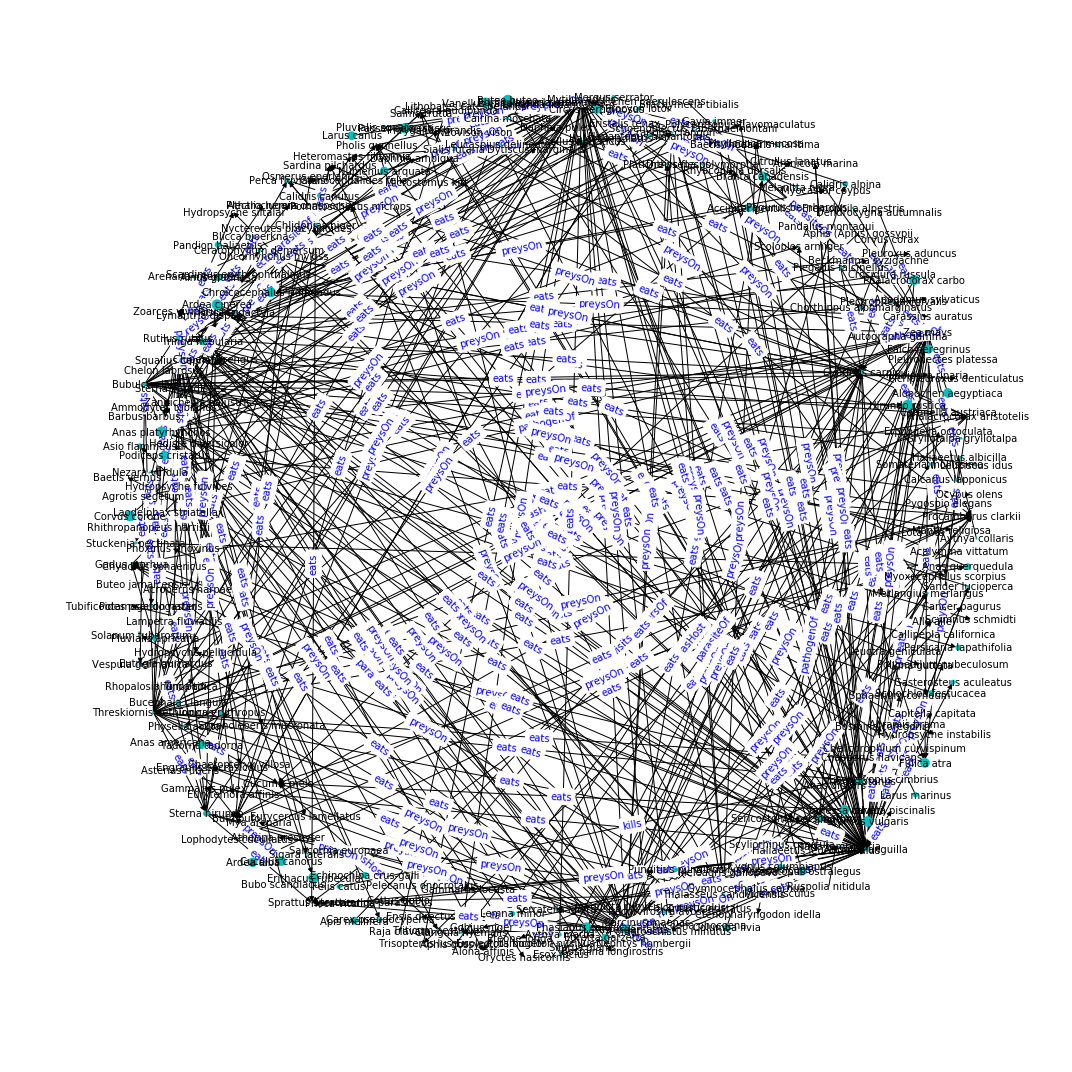

In [62]:
plt.figure(figsize=(15,15))
edge_labels = nx.get_edge_attributes(G,'label')

pos = nx.spring_layout(G, iterations=50, k=50) 
#pos = nx.spring_layout(G)
#pos = nx.random_layout(G)
#pos = nx.circular_layout(G)
#pos = nx.spectral_layout(G)
#pos = nx.shell_layout(G, scale=1)

nodeColors = nx.get_node_attributes(G,'color')

nx.draw_networkx_edge_labels(G,pos, edge_labels = edge_labels, font_size=10, font_color='blue')

#nx.draw_networkx_nodes(G, pos, node_color=nodeColors.values())

nx.draw_networkx(G, pos, with_labels=True, node_size = listOfNodeSizes, node_color='c', alpha= 1, arrows=True, 
                    linewidths=1, font_color="black", font_size=10, style = 'dashed')

plt.axis('off')
plt.tight_layout()
plt.show()

In [63]:
filename = "..\\docs\\"+taxon+country+".html"
with open(filename, "w") as file:
    file.write(" \
<!DOCTYPE html> \
<html> \
<head> \
<script src='../../../GitHub\cytoscape.js\dist\cytoscape.min.js'></script> \
<script src='https://unpkg.com/layout-base/layout-base.js'></script> \
<script src='https://unpkg.com/cose-base/cose-base.js'></script> \
<script src='../../../GitHub\cytoscape.js-cose-bilkent\cytoscape-cose-bilkent.js'></script> \
</head> \
<style>#cy {width: 90%; height: 90%; position: absolute; top: 50px; left: 150px;}\
body {font-family: 'times; font-size: 6px;}\
</style> \
<body> \
<h1><em font-style: italic;>"+taxon+"</em> in "+country+"</h1>")

### Write out the details of the species

In [64]:
with open(filename, "a") as file:
    file.write("<table><th>Species</th><th>Occupancy</th>")
    

In [65]:
species = G.nodes
with open(filename, "a") as file:
    for n in species:
        file.write("<tr><td><a target='_blank' href=https://www.gbif.org/species/"+str(nx.get_node_attributes(G, 'gbifkey')[n])+">"+n+"</a></td><td>"+str(dictOfNodeSizes[n])+"</td>\n")
        #file.write("<a href=https://www.gbif.org/species/"+str(nx.get_node_attributes(G, 'gbifkey')[n])+">"+n+"</a>, "+str(dictOfNodeSizes[n])+"\n")

In [66]:
with open(filename, "a") as file:
    file.write("</table>")    
file.close()

In [67]:
with open(filename, "a") as file:
    file.write(" \
<div id='cy'></div> \
<script> \
var cy = cytoscape({ \
  container: document.getElementById('cy'), \n \
  elements: [ \
")

### Write nodes to file

In [68]:
file = open(filename, "a")
for n in species:
    if n == taxon:
        file.write("{ data: { id: '"+n+"', href: 'https://www.gbif.org/species/"+str(nx.get_node_attributes(G, 'gbifkey')[n])+"', occnum: "+str(dictOfNodeSizes[n])+" }, selectable: true,},\n")
    else:
        file.write("{ data: { id: '"+n+"', href: 'https://www.gbif.org/species/"+str(nx.get_node_attributes(G, 'gbifkey')[n])+"', occnum: "+str(dictOfNodeSizes[n])+" }, selectable: false,},\n")
file.close()

### Write edges to file

In [69]:
file = open(filename, "a")
for edge in G.edges:
    file.write("{data: {id: '"+edge[0]+edge[1]+"', source: '"+edge[0]+"', target: '"+edge[1]+"', label: '"+nx.get_edge_attributes(G, 'label')[edge]+"'}},\n")
file.close()
    

In [70]:
with open(filename, "a") as file:
    file.write("], \
style: [ \n\
        { \n\
            selector: 'node', \n\
            style: { \n\
                shape: 'circle', \n\
                'background-color': 'darkgreen', \n\
                label: 'data(id)', \n\
                'font-family': 'helvetica', \n\
                'font-style': 'italic', \n\
                'font-size': '8px', \n\
                'width': 'mapData(occnum, 0, 400, 3, 200)', \n\
                'height': 'mapData(occnum, 0, 400, 3, 200)' \n\
            } \n\
        },  \n\
        {  \n\
            selector: 'edge',  \n\
            style: {  \n\
                label: 'data(label)', \n\
                'font-family': 'helvetica', \n\
                'font-size': '8px', \n\
                'color': 'blue', \n\
                'curve-style': 'bezier', \n\
                'target-arrow-shape': 'triangle',  \n\
                'width': '1' \n\
                } \n\
            },  \n\
            {  \n\
              selector: ':selected',   \n\
              css: {  \n\
                'line-color': 'red',  \n\
                'background-color': 'red'  \n\
            }  \n\
        }], \n\
layout:  { \n\
            name: 'cose', padding: 5, animate: true, gravity: 30, animationDuration: 1000 \n\
     } \n\
} \n\
); \n\
")

In [71]:
with open(filename, "a") as file:
    file.write("cy.userZoomingEnabled( true ); \n\
    cy.getElementById('"+taxon+"').select(); \n\
    document.write('Degree of node "+taxon+" ='+cy.getElementById('"+taxon+"').degree()); \n\
    </script> \n\
")

In [72]:
with open(filename, "a") as file:
    file.write("<h2>References</h2><ul>\n")

In [73]:
citations = cleanInteractDataTaxon['sourceCitation'].unique()
file = open(filename, "a")
for ref in citations:
    file.write("<li>"+str(ref)+"</li>\n")
file.close()

In [74]:
with open(filename, "a") as file:
    file.write("</ul> \
        </body> \
        </html>")

In [75]:
file.close()

## Output a CSV file for import into Gephi

In [76]:
for node in G.edges:
    print(node[1])

Citrullus lanatus
Cucumis melo
Zea mays
Bubulcus ibis
Tringa totanus
Anas querquedula
Vanellus vanellus
Fulica atra
Phalacrocorax aristotelis
Anas platyrhynchos
Chroicocephalus ridibundus
Larus argentatus
Chlidonias niger
Himantopus himantopus
Anguilla anguilla
Rutilus rutilus
Cyprinus carpio
Procambarus clarkii
Bufo bufo
Mytilus edulis
Ardea cinerea
Thalasseus sandvicensis
Sterna hirundo
Cucumis melo
Cucumis melo
Zea mays
Cucumis melo
Cucumis melo
Zea mays
Zea mays
Zea mays
Anas platyrhynchos
Zea mays
Zea mays
Zea mays
Zea mays
Zea mays
Zea mays
Zea mays
Zea mays
Zea mays
Zea mays
Zea mays
Zea mays
Zea mays
Zea mays
Zea mays
Zea mays
Zea mays
Zea mays
Zea mays
Zea mays
Zea mays
Zea mays
Zea mays
Zea mays
Zea mays
Zea mays
Anas platyrhynchos
Bufo bufo
Zea mays
Zea mays
Zea mays
Zea mays
Zea mays
Zea mays
Bubulcus ibis
Anas platyrhynchos
Larus argentatus
Cyprinus carpio
Mytilus edulis
Fulica atra
Bufo bufo
Mytilus edulis
Hirundo rustica
Athalia lugens
Eristalis tenax
Mantis religiosa
Mu

### For import into Gephi: A nodes and edges file has been replace by the .dot file format

In [77]:
#with open(taxon+"_nodes.csv", "w") as file:
#    file.write("Id,Label,Category")
#    for node in G.nodes:
#        file.write("'"+edge[0]+edge[1]+"','"+edge[0]+"','"+edge[1]+"','"+nx.get_edge_attributes(G, 'label')[edge]+"'\n")
#file.close()

In [78]:
#with open(taxon+"edges.csv", "w") as file:
#    file.write("Id,Label,Category")
#    for node in G.nodes:
#        file.write("'"+edge[0]+edge[1]+"','"+edge[0]+"','"+edge[1]+"','"+nx.get_edge_attributes(G, 'label')[edge]+"'\n")
#file.close()

In [79]:
#with open(taxon+".csv", "w") as file:
write_dot(G, taxon+".dot")